In [67]:
# Datos
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento de datos

In [68]:
df_cleaned_reviews = pd.read_csv('dataset/cleaned-reviews.csv')
df_cleaned_reviews.head()

,Unnamed: 0,reviews,rates,date,country,verified,comments
0,0,✅ Trip Verified | Excellent service both on th...,5,2023-01-24,United Kingdom,True,excellent service ground board first class pro...
1,1,✅ Trip Verified | Good lounge at Cape Town. O...,9,2023-01-24,United Kingdom,True,good lounge cape town time departure drink hig...
2,2,✅ Trip Verified | A really excellent journey....,9,2023-01-23,United Kingdom,True,really excellent journey lounge overcrowded la...
3,3,✅ Trip Verified | This flight was one of the ...,9,2023-01-21,United Kingdom,True,flight one worst ever life wanted pamper bough...
4,4,Not Verified | It seems that there is a race t...,2,2023-01-19,United States,False,verified seems race bottom amongst airline can...


In [69]:
df_cleaned_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3411 entries, 0 to 3410
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3411 non-null   int64 
 1   reviews     3411 non-null   object
 2   rates       3411 non-null   int64 
 3   date        3411 non-null   object
 4   country     3411 non-null   object
 5   verified    3411 non-null   bool  
 6   comments    3411 non-null   object
dtypes: bool(1), int64(2), object(4)
memory usage: 163.3+ KB


In [70]:
# Eliminamos la columna "Unnamed: 0"
df_cleaned_reviews = df_cleaned_reviews.drop(columns=['Unnamed: 0'])

# Convertir la columna "date" a tipo datetime
df_cleaned_reviews['date'] = pd.to_datetime(df_cleaned_reviews['date'])

# Eliminar filas duplicados.
df_cleaned_reviews.drop_duplicates(inplace=True)

In [71]:
# Datos faltantes.
df_cleaned_reviews.isnull().sum()

reviews     0
rates       0
date        0
country     0
verified    0
comments    0
dtype: int64

In [72]:
df_cleaned_reviews.describe()

,rates,date
count,3410.000000,3410
mean,4.819941,2017-05-18 07:24:14.780058624
min,1.000000,2014-05-18 00:00:00
25%,2.000000,2015-08-15 00:00:00
50%,4.000000,2016-12-08 12:00:00
75%,8.000000,2018-09-15 18:00:00
max,10.000000,2023-01-24 00:00:00
std,3.145510,NaN


## filtered_customer_booking.csv

In [73]:
df_filtered = pd.read_csv('dataset/filtered_customer_booking.csv')

In [74]:
df_filtered.head()

,Unnamed: 0,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [75]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49982 entries, 0 to 49981
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             49982 non-null  int64  
 1   num_passengers         49982 non-null  int64  
 2   sales_channel          49982 non-null  object 
 3   trip_type              49982 non-null  object 
 4   purchase_lead          49982 non-null  int64  
 5   length_of_stay         49982 non-null  int64  
 6   flight_hour            49982 non-null  int64  
 7   flight_day             49982 non-null  int64  
 8   route                  49982 non-null  object 
 9   booking_origin         49982 non-null  object 
 10  wants_extra_baggage    49982 non-null  int64  
 11  wants_preferred_seat   49982 non-null  int64  
 12  wants_in_flight_meals  49982 non-null  int64  
 13  flight_duration        49982 non-null  float64
 14  booking_complete       49982 non-null  int64  
dtypes:

In [76]:
df_filtered.describe()

,Unnamed: 0,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000,49982.000000
mean,24999.957905,1.591133,84.754652,23.046757,9.065344,3.814253,0.668881,0.297047,0.427174,7.277333,0.149574
std,14433.587942,1.020217,89.923276,33.892624,5.412551,1.992722,0.470621,0.456962,0.494673,1.496829,0.356657
min,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,12500.250000,1.000000,21.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,25000.500000,1.000000,51.000000,17.000000,9.000000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,37498.750000,2.000000,115.000000,28.000000,13.000000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,49999.000000,9.000000,495.000000,778.000000,23.000000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [77]:
# Eliminamos la columna "Unnamed: 0"
df_filtered = df_filtered.drop(columns=['Unnamed: 0'])

### sales_channel

In [78]:
df_filtered.sales_channel.value_counts()

sales_channel
Internet    44366
Mobile       5616
Name: count, dtype: int64

In [79]:
# Convertimos a variable categórica
df_filtered['sales_channel'] = df_filtered['sales_channel'].astype('category')

### trip_type

In [80]:
df_filtered.trip_type.value_counts()

trip_type
RoundTrip     49479
OneWay          387
CircleTrip      116
Name: count, dtype: int64

In [81]:
# Convertimos a variable categórica
df_filtered['trip_type'] = df_filtered['trip_type'].astype('category')

### route

In [82]:
df_filtered['route'].value_counts()

route
AKLKUL    2678
PENTPE     924
MELSGN     842
ICNSIN     801
DMKKIX     744
          ... 
LBUTPE       1
CXRMEL       1
DELKBR       1
KOSSYD       1
MRUXIY       1
Name: count, Length: 799, dtype: int64

In [83]:
# Convertimos a variable categórica
df_filtered['route'] = df_filtered['route'].astype('category')

### booking_origin

In [84]:
df_filtered['booking_origin'].value_counts()

booking_origin
Australia               17865
Malaysia                 7173
South Korea              4559
Japan                    3884
China                    3387
                        ...  
Panama                      1
Tonga                       1
Tanzania                    1
Bulgaria                    1
Svalbard & Jan Mayen        1
Name: count, Length: 104, dtype: int64

In [85]:
# Convertimos a variable categórica
df_filtered['booking_origin'] = df_filtered['booking_origin'].astype('category')

# Graficos

In [86]:
cantidad = df_cleaned_reviews.rates.value_counts().sort_index()

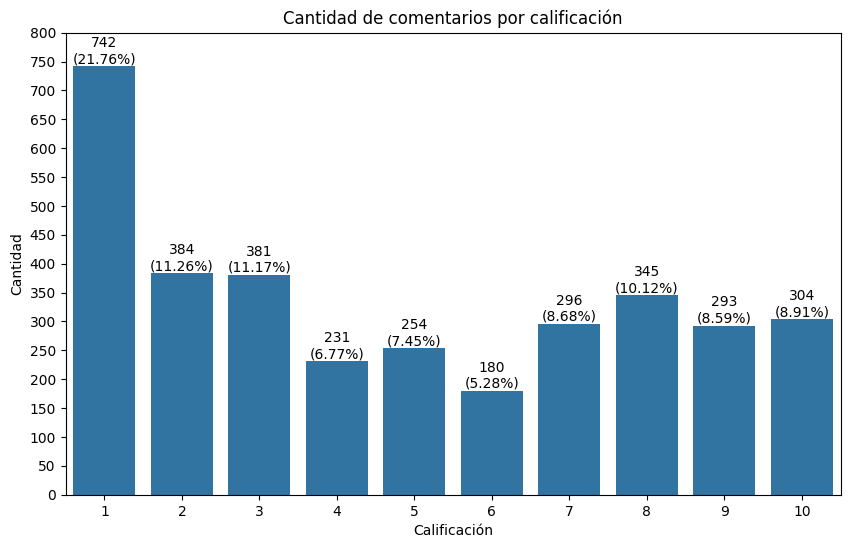

In [87]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cantidad.index, y=cantidad.values)
plt.title('Cantidad de comentarios por calificación')
plt.xlabel('Calificación')
plt.ylabel('Cantidad')

for i in range(cantidad.shape[0]):
    plt.text(i, cantidad.values[i], f'{cantidad.values[i]}\n({cantidad.values[i]/cantidad.sum()*100:.2f}%)', ha='center', va='bottom')

plt.yticks(range(0, 850, 50))

plt.show()

Text(0.5, 1.0, 'Distribución de la variable "purchase_lead"')

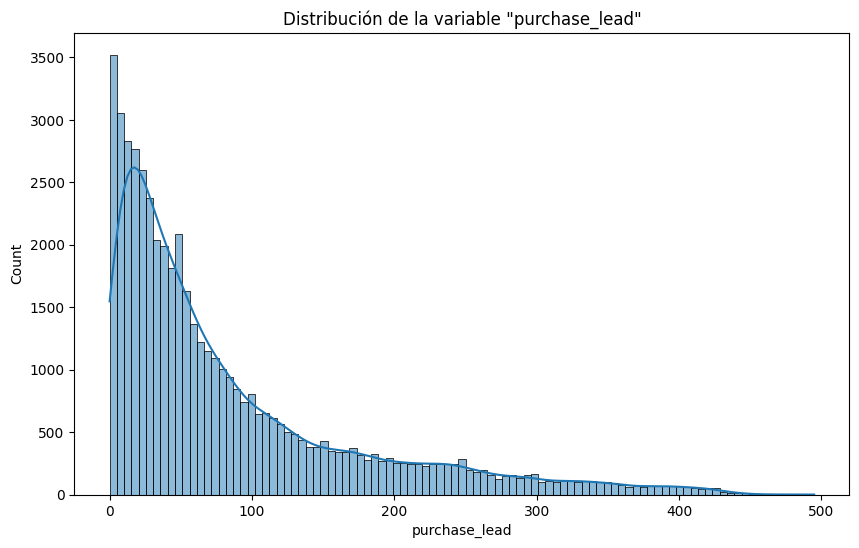

In [88]:
# Graficams la distribución 	purchase_lead
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered.purchase_lead, kde=True)
plt.title('Distribución de la variable "purchase_lead"')